# Autoencoders for time series anomaly detection

In this example, we are going to use an autoencoder architecture to perform anomaly detection on time series. We will keep the example simple with not many layers for the encoder and the decoder, but it is possible to expand and make the model more complicated. 

For the purpose of this illustration, we will use LSTM layers that are well fitted for time series analysis as they are able to learn time dependencies. 

We'll create a model with one Keras layer for the encoder and another one for the decoder, though both of those layers will have multiple units (i.e. layers within them). 

To illustrate this, we will use a dataset from the Numenta Anomaly Benchmark, available here: https://github.com/numenta/NAB/tree/master/data. 

We'll use the dataset `art_daily_small_noise.csv` located in the `artificialNoAnomaly` folder to train the network and we will use the dataset `art_daily_jumpsdown.csv` located in the `artificialWithAnomaly` folder to detect anomalies.

In [199]:
from keras import Sequential
import keras.layers as layers
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from typing import Tuple, List
import keras
from pathlib import Path
import requests
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

register_matplotlib_converters()
sns.set_style('darkgrid')

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [200]:
DATA_DIR = Path('Data')
DATA_FILE_NORM = 'art_daily_small_noise.csv'
DATA_URL_NORM = 'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialNoAnomaly/art_daily_small_noise.csv'
DATA_FILE_ABN = 'art_daily_jumpsdown.csv'
DATA_URL_ABN = 'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialWithAnomaly/art_daily_jumpsdown.csv'

DATA_NORM = DATA_DIR / DATA_FILE_NORM
DATA_ABN = DATA_DIR / DATA_FILE_ABN

if not Path(DATA_DIR).exists():
    DATA_DIR.mkdir()

def get_data(data_path: Path, url: str) -> pd.DataFrame:
    if not Path(data_path).is_file():
        data = requests.get(url)
        data.raise_for_status()

        with open(data_path, "w") as f:
            f.write(data.text)

    return pd.read_csv(data_path)

In [201]:
normal = get_data(DATA_NORM, DATA_URL_NORM)
abn = get_data(DATA_ABN, DATA_URL_ABN)

In [202]:
normal.shape

(4032, 2)

In [203]:
normal.head()

,timestamp,value
0,2014-04-01 00:00:00,18.324919
1,2014-04-01 00:05:00,21.970327
2,2014-04-01 00:10:00,18.624806
3,2014-04-01 00:15:00,21.953684
4,2014-04-01 00:20:00,21.909120


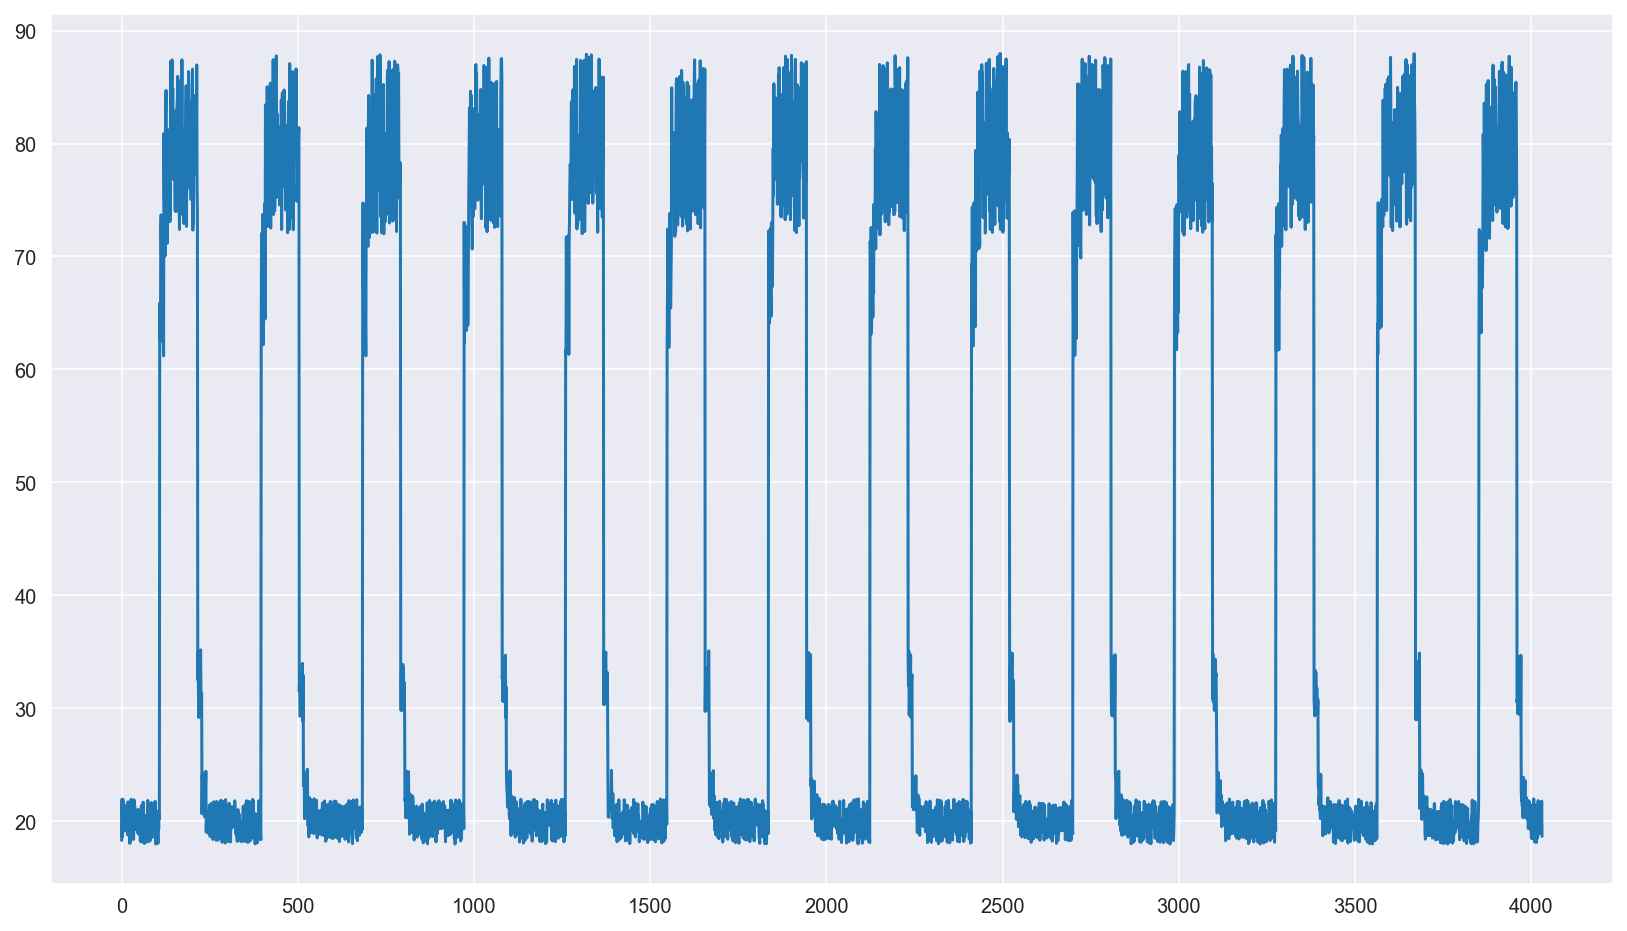

In [204]:
plt.figure(figsize=(14,8))
plt.plot(normal['value'])

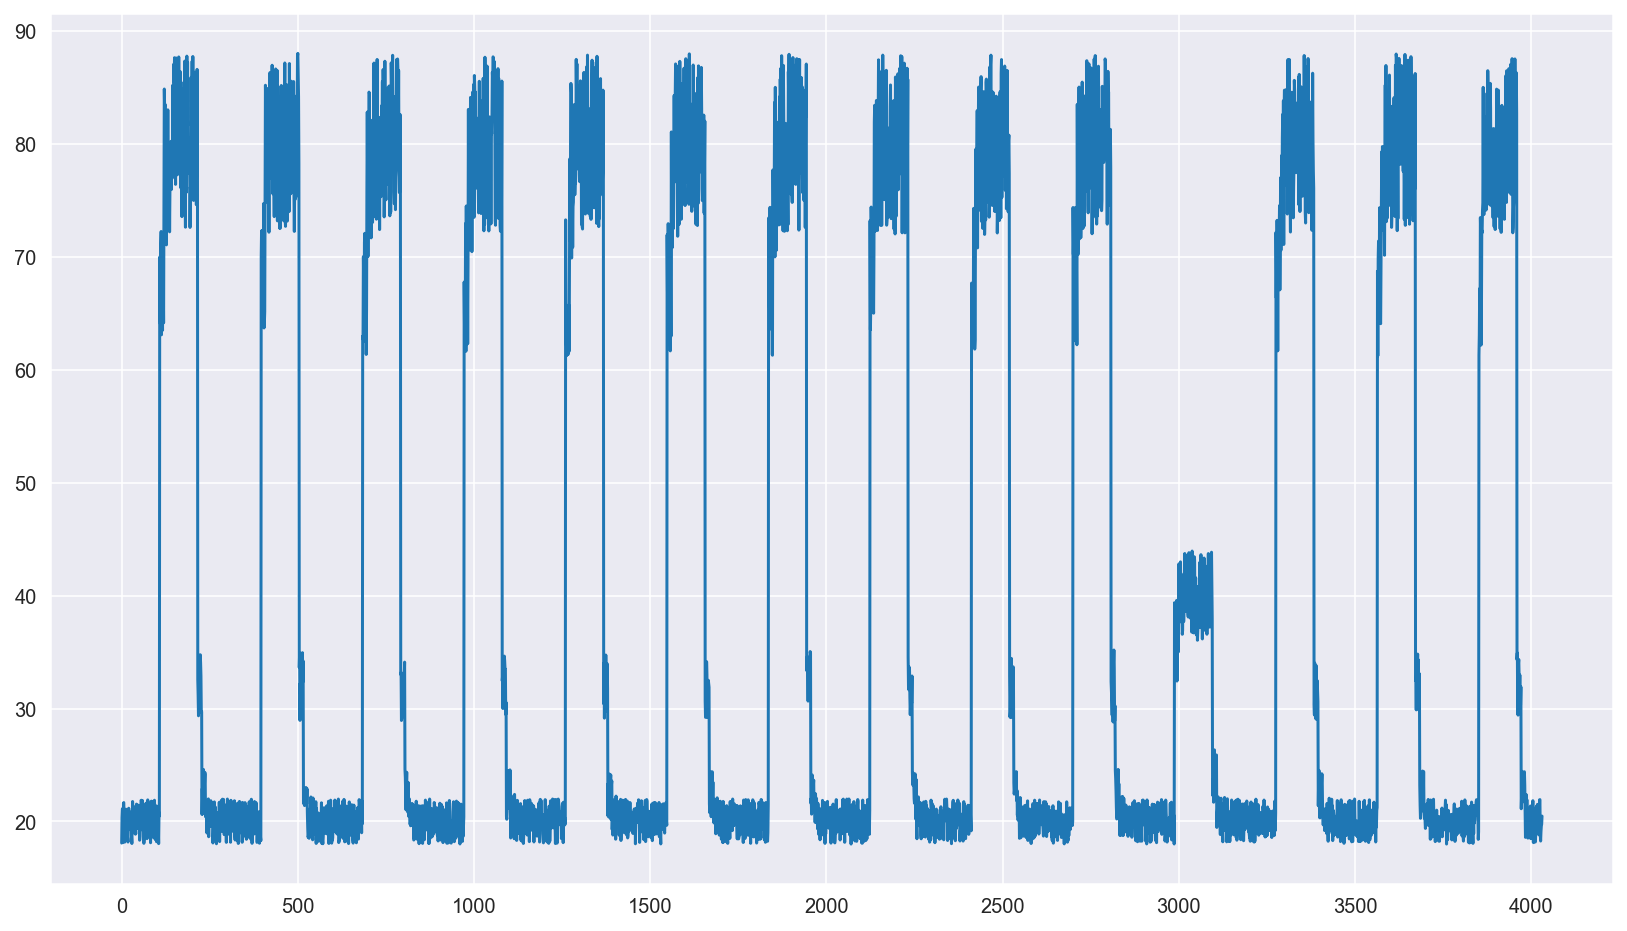

In [205]:
plt.figure(figsize=(14,8))
plt.plot(abn['value'])

## Scaling data

In this case, we are going to pre-process the data using the `MinMaxScaler` object from `Scikit-Learn`. This is will scale data to a given range. Another potential object for pre-processing is `StandardScaler`. 

Our training data is noisy so we we should apply additional steps such as smoothing. We won't do this to see what will be the result of our test.

In [206]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(normal['value'].values.reshape(-1,1))
scaler.data_min_, scaler.data_max_

(array([18.00096402]), array([87.97612833]))

In [207]:
normal['rescaled'] = scaler.transform(normal['value'].values.reshape(-1,1))
abn['rescaled'] = scaler.transform(abn['value'].values.reshape(-1,1))

In [208]:
normal.head()

,timestamp,value,rescaled
0,2014-04-01 00:00:00,18.324919,-0.990741
1,2014-04-01 00:05:00,21.970327,-0.886549
2,2014-04-01 00:10:00,18.624806,-0.982170
3,2014-04-01 00:15:00,21.953684,-0.887025
4,2014-04-01 00:20:00,21.909120,-0.888299


In [209]:
abn.head()

,timestamp,value,rescaled
0,2014-04-01 00:00:00,18.090486,-0.997441
1,2014-04-01 00:05:00,20.359843,-0.932580
2,2014-04-01 00:10:00,21.105470,-0.911268
3,2014-04-01 00:15:00,21.151585,-0.909950
4,2014-04-01 00:20:00,18.137141,-0.996108


## Preparing the datasets

We prepare the datesets by sliding a window on the rescaled data. The target data is the same as the input data, as the key principle of autoencoders is the rebuild the input using a low dimensional representation of the input data.

In [210]:
def create_sequence(sequence: np.ndarray, window: int) -> np.ndarray:
    inputs = []

    nb_items = sequence.shape[0]
    max_range = nb_items - window + 1

    for i in range(max_range):
        x_temp = sequence[i:i + window, :]
        inputs.append(x_temp)

    return np.array(inputs)

In [211]:
window = 60
normal_ds = create_sequence(normal['rescaled'].values.reshape(-1,1), window=window)
abn_ds = create_sequence(abn['rescaled'].values.reshape(-1,1), window=window)

## Creating the autoencoder model

We create a funtion that will return the autoencoder model consisting of the following layers:
- an LSTM layer
- a dropout layer
- an LSTM layer
- a dropout layer
- a dense layer

The dropout layers help to prevent overfitting, though it may be interesting to see what the model would give without them. 

There are also additional layers in the model: `RepeatVector` and `TimeDistributed`. They are here to ensure data will have the proper dimensions for `RepeatVector` and to ensure the same operations are applied to all timesteps for `TimeDistributed`. 

In [212]:
def create_model(window: int, dimensions:int, lstm_internal_dim: int) -> Sequential:
    model = Sequential()
    # Encoder
    model.add(layers.LSTM(units=lstm_internal_dim, input_shape=(window, dimensions)))
    model.add(layers.Dropout(0.3))
    model.add(layers.RepeatVector(n=window))
    # Decoder
    model.add(layers.LSTM(units=lstm_internal_dim, return_sequences=True))
    model.add(layers.Dropout(0.3))
    model.add(layers.TimeDistributed(layers.Dense(units=dimensions)))
    
    return model

In [213]:
learning_rate = 0.001
epochs = 50
batch_size = 32
lstm_internal_dim = 128

In [214]:
model = create_model(window=window, dimensions=1, lstm_internal_dim=lstm_internal_dim)
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
repeat_vector_10 (RepeatVect (None, 60, 128)           0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 60, 128)           131584    
_________________________________________________________________
dropout_21 (Dropout)         (None, 60, 128)           0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, 60, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_______________________________________________

In [215]:
loss_function = keras.losses.MeanAbsoluteError()
model.compile(optimizer='Adam', loss=loss_function, metrics=[keras.metrics.MeanAbsoluteError()])

In [216]:
history = model.fit(normal_ds, normal_ds, epochs=epochs, verbose=0)

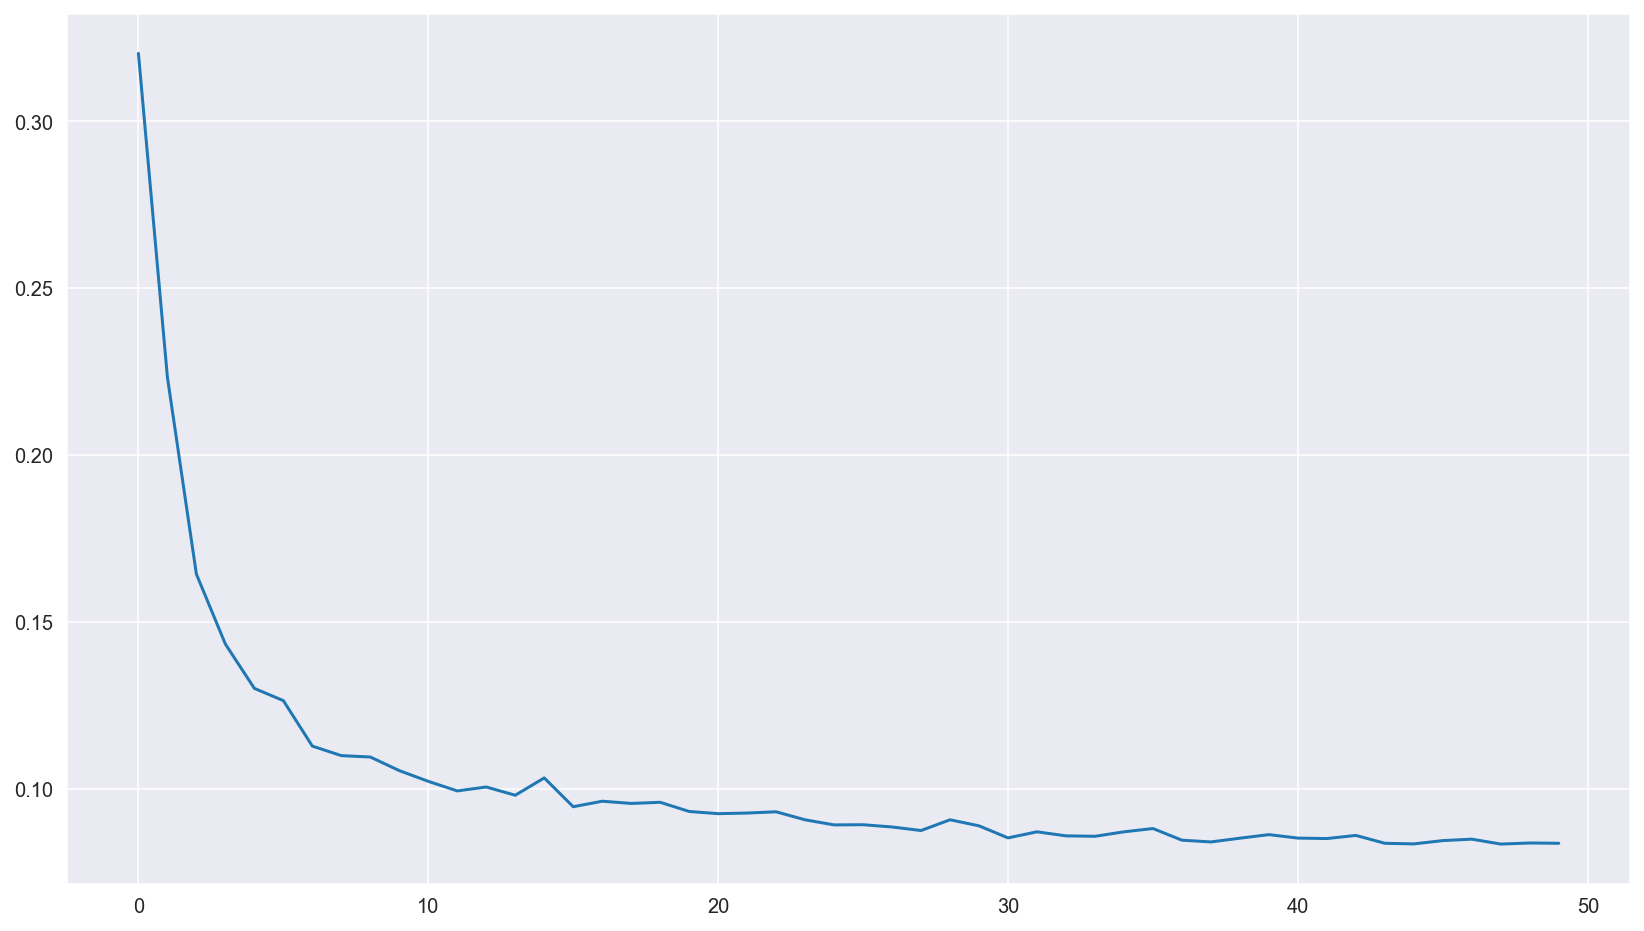

In [217]:
loss = history.history['loss']
plt.figure(figsize=(14,8))
plt.plot(np.array(loss))

In [218]:
prediction = model.predict(abn_ds)

## Rebuilding the series

We create a simple function that is going to rebuild the series as we now have a 3-dimension tensor representing the time series to be fed to the model. 

In [219]:
prediction.shape

(3973, 60, 1)

In [220]:
def rebuild_series(series: np.ndarray) -> np.ndarray:
    max_range = series.shape[0]
    rebuild = np.array([])
    rebuild = np.append(rebuild, series[:max_range-1,0,0])
    rebuild = np.append(rebuild, series[max_range-1, :,0])
        
    return rebuild

In [221]:
abn_rebuild = rebuild_series(prediction)
abn_rebuild.shape

(4032,)

In [222]:
abn_rescaled = scaler.inverse_transform(abn_rebuild.reshape(-1,1))

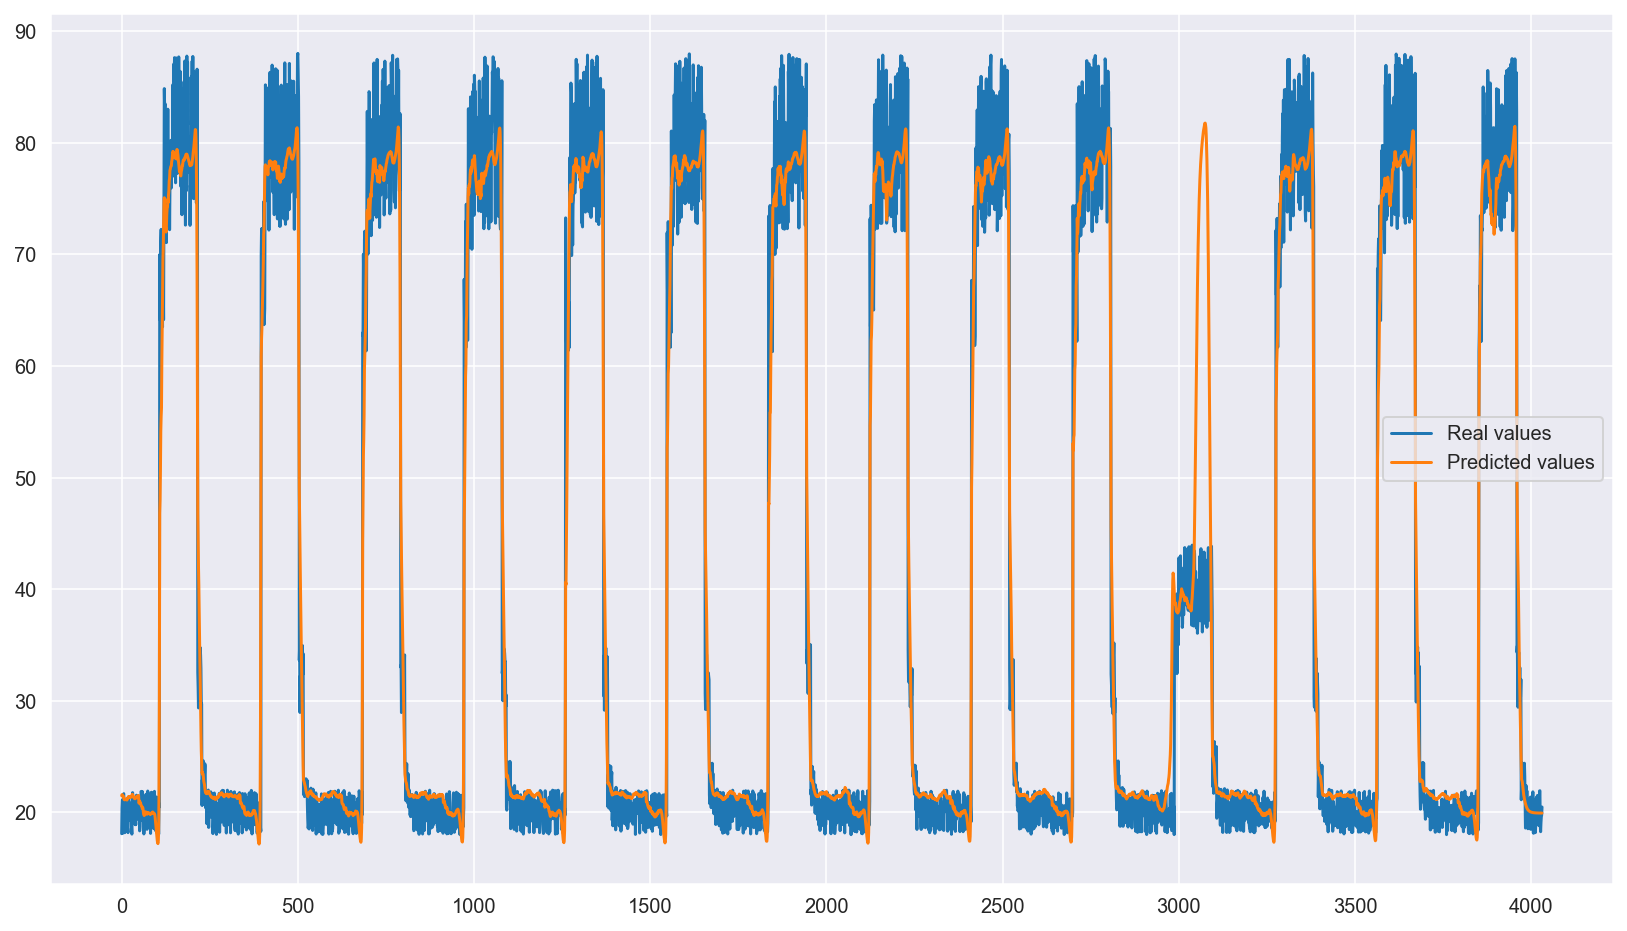

In [223]:
fig, ax = plt.subplots(figsize=(14,8))
ax.plot(abn['value'].values, label='Real values')
ax.plot(abn_rescaled, label='Predicted values')
ax.legend()
plt.show()

## Anomaly predictor

Let's build an anomaly score as the Euclidean distance between the predicted datapoint and the real datapoint. 
If the anomaly score is above a certain threshold then an anomaly is raised. This threshold is domain dependent.

The following function calculates the distance between all the predicted datapoints and their real targets. 

In [224]:
def distance_calculator(scaler: MinMaxScaler, model: Sequential, 
                        input_data: np.ndarray, target: np.ndarray) -> np.ndarray:
    distance = []
    prediction = model.predict(input_data, verbose=0)
    rebuild = rebuild_series(prediction)   
    rescaled = scaler.inverse_transform(rebuild.reshape(-1,1))

    for i in range(rescaled.shape[0]):
        d = np.linalg.norm(rescaled[i,:] - target[i].reshape(-1,1), ord=2)
        distance.append(d)
        
    return np.array(distance)

In [225]:
distance = distance_calculator(scaler, model, abn_ds, abn['value'].values)

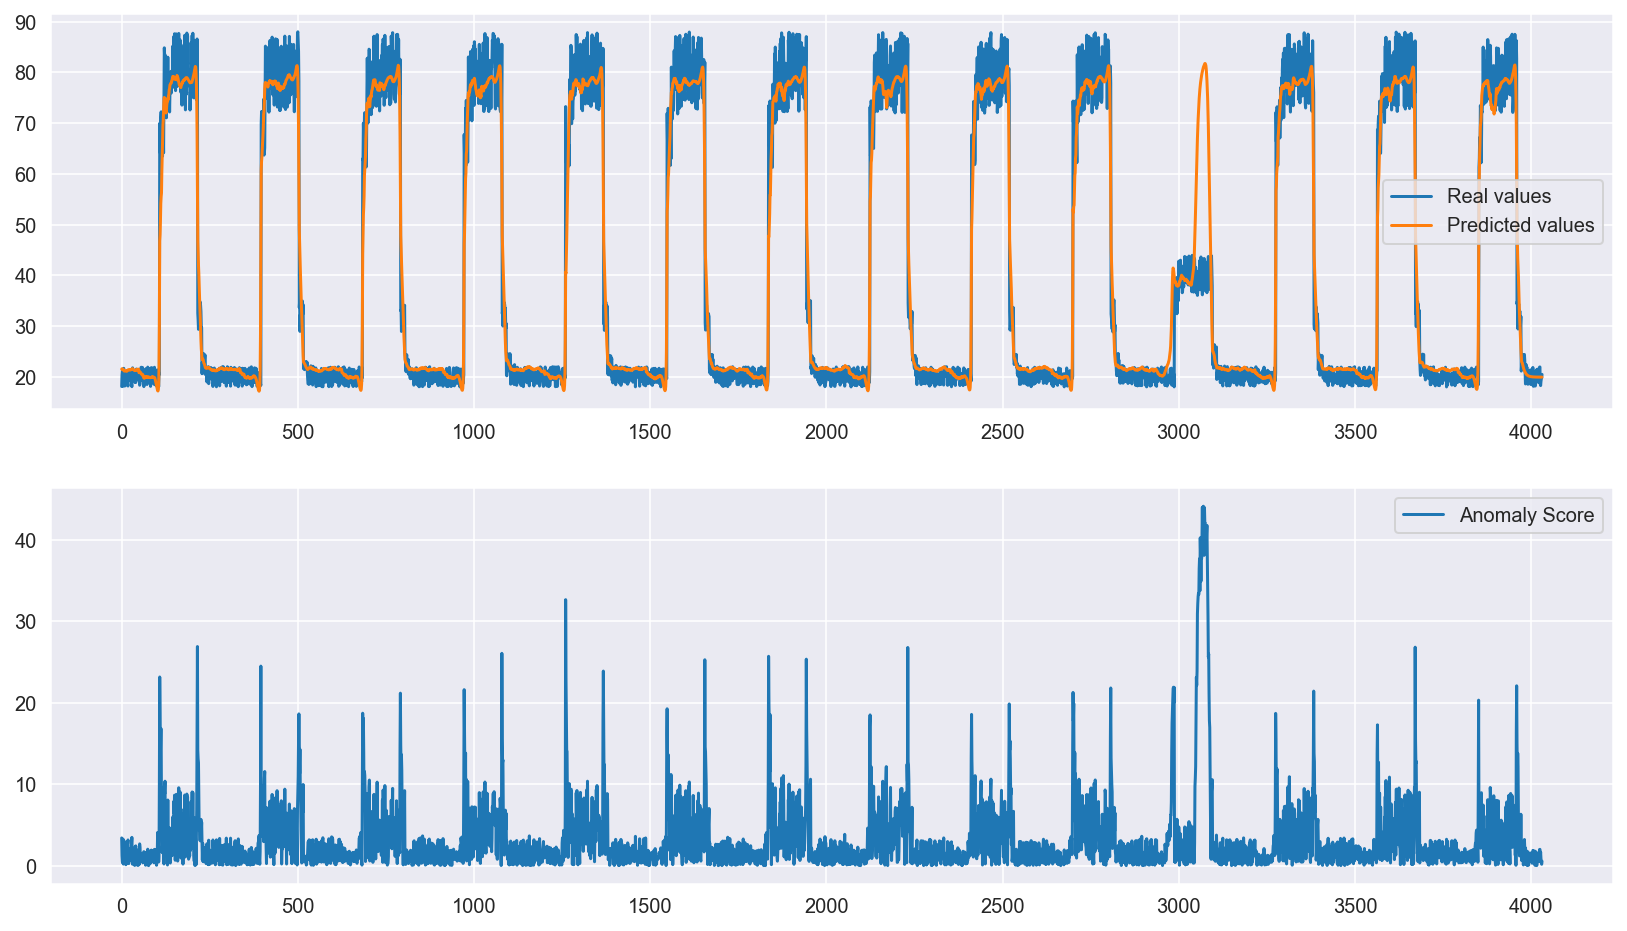

In [226]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,8))
ax1.plot(abn['value'].values, label='Real values')
ax1.plot(abn_rescaled, label='Predicted values')

ax2.plot(distance, label='Anomaly Score')

ax1.legend()
ax2.legend()
plt.show()

## What could be a potential threshold? 

By rebuilding the normal time series (i.e. without anomaly), we can try to determine a threshold by looking at the reconstruction error using the anomaly predictor above. 

In [227]:
distance_norm = distance_calculator(scaler, model, normal_ds, normal['value'].values)

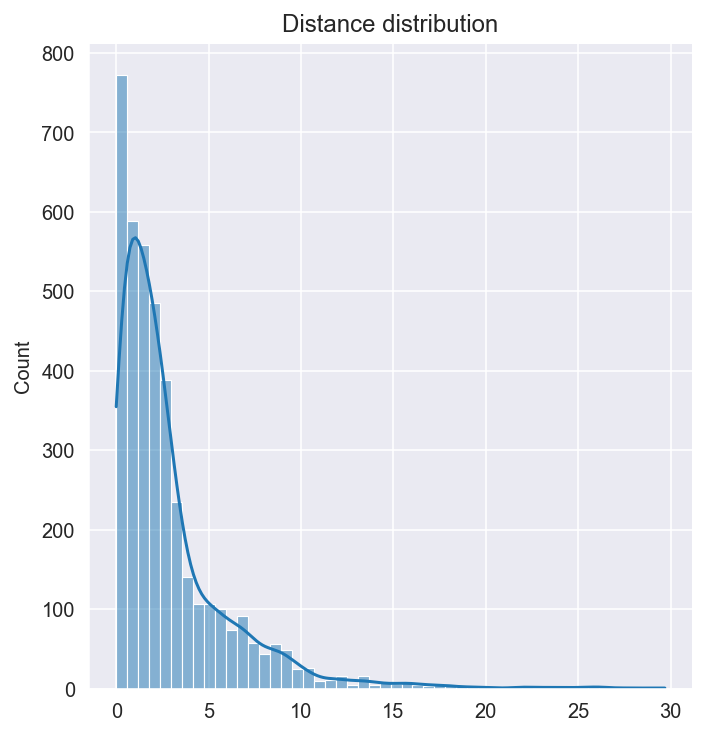

In [228]:
sns.displot(distance_norm, bins=50, kde=True)
plt.title("Distance distribution")
plt.show()

In [229]:
threshold = np.max(distance_norm)
threshold

29.693463243189676